# 13 흉부 엑스선 기반 폐렴 진단
- [DATA](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)
- [EDA](https://www.kaggle.com/code/werooring/ch13-eda)

### 13.2.1 데이터 둘러보기

In [2]:
# 데이터 경로
data_path = '/Users/polaris/projects/Kaggle/9th-Mastering-Kaggle/lecture/ch13/data/'

# 훈련, 검증, 테스트 데이터 경로 설정
train_path = data_path + 'train/'
valid_path = data_path + 'val/'
test_path = data_path + 'test/'

In [3]:
from glob import glob

print(f'훈련 데이터 개수 : {len(glob(train_path + "*/*"))}')
print(f'검증 데이터 개수 : {len(glob(valid_path + "*/*"))}')
print(f'테스트 데이터 개수 : {len(glob(test_path + "*/*"))}')

훈련 데이터 개수 : 5216
검증 데이터 개수 : 16
테스트 데이터 개수 : 624


In [4]:
all_normal_imgs = []    # 모든 정상 이미지를 담을 리스트 초기화
all_pneumonia_imgs = [] # 모든 폐렴 이미지를 담을 리스트 초기화

for cat in ['train/', 'val/', 'test/']:
    data_cat_path = data_path + cat
    # 정상, 폐렴 이미지 경로
    normal_imgs = glob(data_cat_path + 'NORMAL/*')
    pneumonia_imgs = glob(data_cat_path + 'PNEUMONIA/*')
    # 정상, 폐렴 이미지 경로를 리스트에 추가
    all_normal_imgs.extend(normal_imgs)
    all_pneumonia_imgs.extend(pneumonia_imgs)

print(f'정상 흉부 이미지 개수 : {len(all_normal_imgs)}')
print(f'폐렴 흉부 이미지 개수 : {len(all_pneumonia_imgs)}')

정상 흉부 이미지 개수 : 1583
폐렴 흉부 이미지 개수 : 4273


### 13.2.2 데이터 시각화

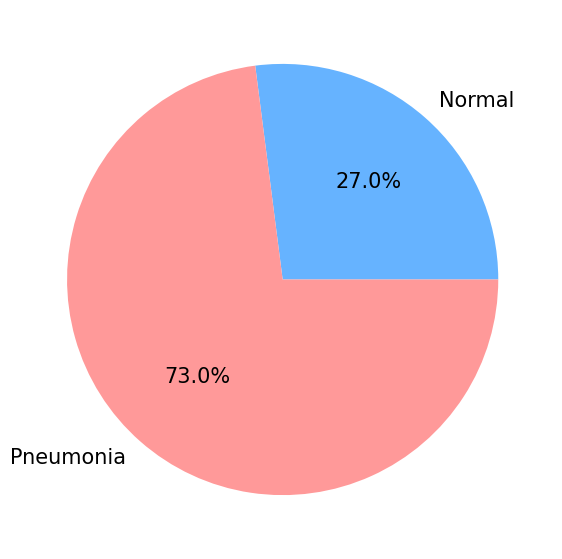

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['Normal', 'Pneumonia'] # 타깃값 레이블
colors = ['#66b3ff', '#ff9999']  # 원하는 색상 설정
# 타깃값 분포 파이 그래프
plt.pie([len(all_normal_imgs), len(all_pneumonia_imgs)], 
        labels=label,
        colors= colors,
        autopct='%.1f%%');

In [6]:
import matplotlib.gridspec as gridspec
import cv2

def show_image(img_paths, rows=2, cols=3): 
    assert len(img_paths) <= rows*cols # 이미지가 행/열 개수보다 많으면 오류 발생
    
    mpl.rc('font', size=8)
    plt.figure(figsize=(15, 8)) 
    grid = gridspec.GridSpec(rows, cols) # 서브플롯 배치

    # 이미지 출력
    for idx, img_path in enumerate(img_paths):
        image = cv2.imread(img_path) # 이미지 파일 읽기
        ax = plt.subplot(grid[idx])
        ax.imshow(image) # 이미지 출력

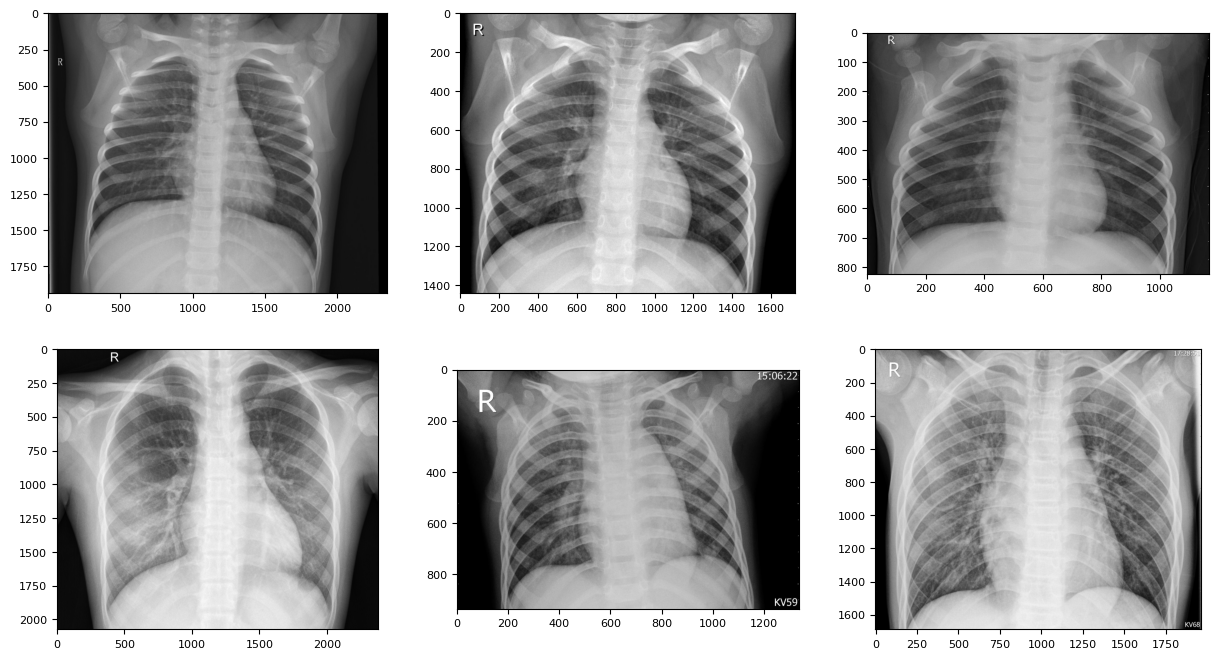

In [7]:
# 정상 엑스선 이미지 경로(마지막 6장)
num_of_imgs = 6
normal_img_paths = all_normal_imgs[-num_of_imgs:]

# 이미지 출력
show_image(normal_img_paths)

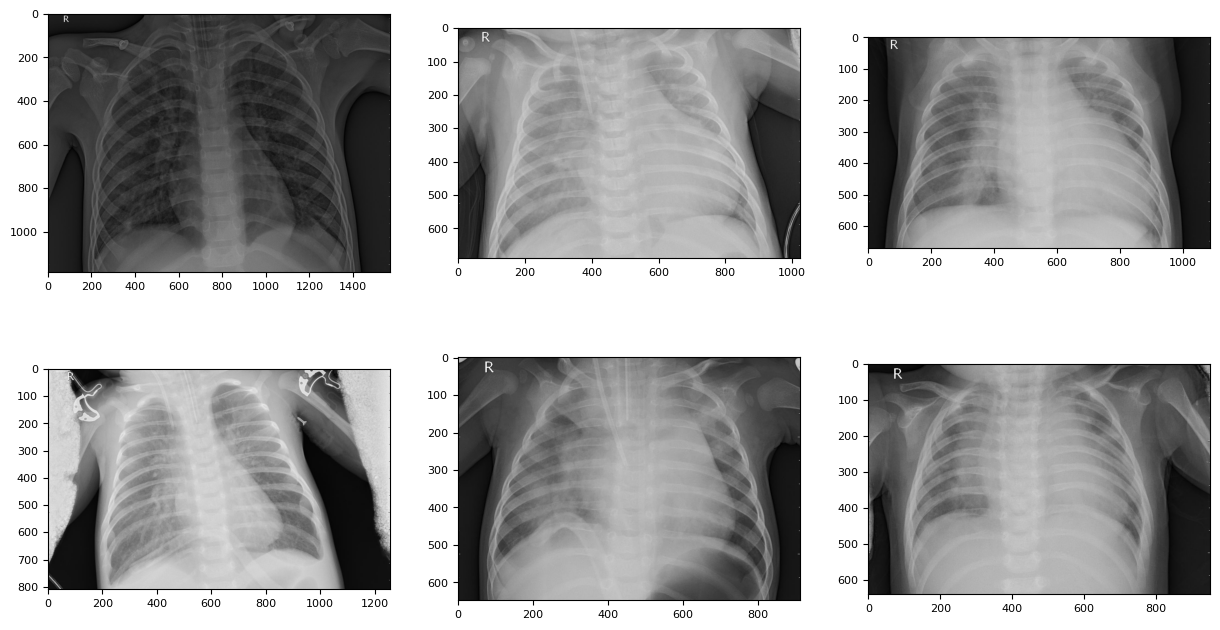

In [8]:
# 폐렴 엑스선 이미지 경로(마지막 6장)
pneumonia_img_paths = all_pneumonia_imgs[-num_of_imgs:]

# 이미지 출력
show_image(pneumonia_img_paths)

### 13.3 흉부 엑스선 기반 폐렴 진단 베이스라인 모델

#### 13.3.1 시드 값 고정 및 GPU 장비 설정

In [9]:
import torch # 파이토치 
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 13.3.2 데이터 준비

In [11]:
# 데이터 경로
data_path = '/Users/polaris/projects/Kaggle/9th-Mastering-Kaggle/lecture/ch13/data/'

# 훈련, 검증, 테스트 데이터 경로 설정
train_path = data_path + 'train/'
valid_path = data_path + 'val/'
test_path = data_path + 'test/'

In [12]:
from torchvision import transforms

# 훈련 데이터용 변환기
transform_train = transforms.Compose([
                          transforms.Resize((250, 250)),      # 이미지 크기 조정 
                          transforms.CenterCrop(180),         # 중앙 이미지 확대
                          transforms.RandomHorizontalFlip(0.5), # 좌우 대칭
                          transforms.RandomVerticalFlip(0.2), # 상하 대칭
                          transforms.RandomRotation(20),      # 이미지 회전
                          transforms.ToTensor(),              # 텐서 객체로 변환
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))]) # 정규화

# 테스트 데이터용 변환기
transform_test = transforms.Compose([
                          transforms.Resize((250, 250)),
                          transforms.CenterCrop(180),
                          transforms.ToTensor(),
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))])

In [13]:
from torchvision.datasets import ImageFolder

# 훈련 데이터셋
datasets_train = ImageFolder(root=train_path, transform=transform_train)
# 검증 데이터셋
datasets_valid = ImageFolder(root=valid_path, transform=transform_test) 

In [14]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 제너레이터 시드값 고정
g = torch.Generator()
g.manual_seed(0)

In [15]:
from torch.utils.data import DataLoader

batch_size = 8

loader_train = DataLoader(dataset=datasets_train, batch_size=batch_size, 
                          shuffle=True,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset=datasets_valid, batch_size=batch_size, 
                          shuffle=False,
                          generator=g, num_workers=2)

### 13.3.3 모델 생성

In [16]:
from efficientnet_pytorch import EfficientNet
# 모델 생성
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2) 
# 장비 할당
model = model.to(device)
print('모델 파라미터 개수 :', sum(param.numel() for param in model.parameters()))

Loaded pretrained weights for efficientnet-b0
모델 파라미터 개수 : 4010110


### 13.3.4 모델 훈련 및 성능 검증

In [17]:
import torch.nn as nn

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
# 훈련 함수 작성

from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score   # 재현율 계산 함수
from sklearn.metrics import f1_score       # F1 점수 계산 함수
from tqdm.notebook import tqdm             # 진행률 표시 막대
import wandb

def train(model, loader_train, loader_valid, criterion, optimizer, 
          scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용) 

    # 총 에폭만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
        # == [ 훈련 ] ==============================================
        model.train()        # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
        # '반복 횟수'만큼 반복 
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
            images = images.to(device)
            labels = labels.to(device)
            
            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad()
            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
            outputs = model(images)
            # 손실 함수를 활용해 outputs와 labels의 손실값 계산
            loss = criterion(outputs, labels)
            # 현재 배치에서의 손실 추가 (훈련 데이터용)
            epoch_train_loss += loss.item()
            
            
            loss.backward()       # 역전파 수행
            optimizer.step()      # 가중치 갱신
            if scheduler != None: # 스케줄러 학습률 갱신 
                scheduler.step() 

        train_loss = round(epoch_train_loss/len(loader_train), 3)
        wandb.log({"epoch_train_loss": train_loss}) 
        
        # 훈련 데이터 손실값 출력
        print(f'\t훈련 데이터 손실값 : {train_loss}')
        
        # == [ 검증 ] ==============================================
        model.eval()         # 모델을 평가 상태로 설정 
        epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용)
        preds_list = []      # 예측값 저장용 리스트 초기화
        true_list = []       # 실젯값 저장용 리스트 초기화
        
        with torch.no_grad(): # 기울기 계산 비활성화
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()
                
                
                # 예측값 및 실제값 
                preds = torch.max(outputs.cpu(), dim=1)[1].numpy() 
                true = labels.cpu().numpy() 
    
                preds_list.extend(preds)
                true_list.extend(true)
                
        # 정확도, 재현율, F1 점수 계산
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)

        # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
        valid_loss = round(epoch_valid_loss/len(loader_valid),3)
        
        print(f'\t검증 데이터 손실값 : {valid_loss}')
        
        wandb.log({"epoch_valid_loss": valid_loss})
        wandb.log({"accurate": round(val_accuracy,3)})
        wandb.log({"recall": round(val_recall,3)})
        wandb.log({"f1_score": round(val_f1_score,3)})
         
        
        print(f'\t정확도 : {val_accuracy:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')
        # == [ 최적 모델 가중치 찾기 ] ==============================
        # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장 
        if epoch_valid_loss <= valid_loss_min: 
            print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}). 모델 저장')
            # 모델 가중치를 파일로 저장 
            torch.save(model.state_dict(), save_file) 
            valid_loss_min = epoch_valid_loss # 최소 손실값 갱신 
    return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

In [19]:
wandb.init(project="Kaggel_ch13",
           dir=r"/Users/polaris/projects/Kaggle/9th-Mastering-Kaggle/lecture/ch13/wandb")

# 모델 훈련
model_state_dict = train(model=model,
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer)

wandb: Currently logged in as: ryan170521. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


에폭 [1/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.388
	검증 데이터 손실값 : 1.304
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
	### 검증 데이터 손실값 감소 (inf --> 2.6079). 모델 저장
에폭 [2/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.24
	검증 데이터 손실값 : 1.443
	정확도 : 0.5000 / 재현율 : 1.0000 / F1 점수 : 0.6667
에폭 [3/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.22
	검증 데이터 손실값 : 0.49
	정확도 : 0.7500 / 재현율 : 0.8750 / F1 점수 : 0.7778
	### 검증 데이터 손실값 감소 (2.6079 --> 0.9809). 모델 저장
에폭 [4/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.186
	검증 데이터 손실값 : 4.5
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [5/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.178
	검증 데이터 손실값 : 1.987
	정확도 : 0.5000 / 재현율 : 1.0000 / F1 점수 : 0.6667
에폭 [6/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.173
	검증 데이터 손실값 : 0.439
	정확도 : 0.7500 / 재현율 : 0.8750 / F1 점수 : 0.7778
	### 검증 데이터 손실값 감소 (0.9809 --> 0.8774). 모델 저장
에폭 [7/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.163
	검증 데이터 손실값 : 1.499
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273
에폭 [8/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.175
	검증 데이터 손실값 : 0.83
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [9/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.149
	검증 데이터 손실값 : 1.268
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [10/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.153
	검증 데이터 손실값 : 0.776
	정확도 : 0.6875 / 재현율 : 0.3750 / F1 점수 : 0.5455


/var/folders/_s/ysfls8x16d943c0j4j3jfcwr0000gn/T/ipykernel_35265/118410405.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(save_file) # 저장한 모델 가중치를 불러

In [20]:
# 최적 가중치 불러오기
model.load_state_dict(model_state_dict)

<All keys matched successfully>

### 13.3.5 예측 및 평가 결과

In [32]:
datasets_test = ImageFolder(root=test_path, transform=transform_test)

loader_test = DataLoader(dataset=datasets_test, batch_size=batch_size, 
                         shuffle=False,
                         generator=g, num_workers=2)

In [42]:
def predict(model, loader_test, return_true=False):
    model.eval()    # 모델을 평가 상태로 설정
    preds_list = [] # 예측값 저장용 리스트 초기화
    true_list = []  # 실제값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성
        for images, labels in loader_test:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            preds = torch.max(outputs.cpu(), dim=1)[1].numpy() # 예측값
            true = labels.cpu().numpy() # 실제값 

            preds_list.extend(preds)
            true_list.extend(true)

    if return_true:
        return true_list, preds_list
    else:
        return preds_list

In [34]:
true_list, preds_list = predict(model=model, 
                                loader_test=loader_test, 
                                return_true=True)

In [35]:
print('#'*5, '최종 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list):.4f}')

##### 최종 예측 결과 평가 점수 #####
정확도 : 0.8478
재현율 : 0.9615
F1 점수 : 0.8876


## 13.4 성능 개선

### 13.4.1 모델 생성

In [18]:
models_list = [] # 모델 저장용 리스트

In [19]:
import torch
from efficientnet_pytorch import EfficientNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 생성
efficientnet_b1 = EfficientNet.from_pretrained('efficientnet-b1', num_classes=2)
efficientnet_b2 = EfficientNet.from_pretrained('efficientnet-b2', num_classes=2)
efficientnet_b3 = EfficientNet.from_pretrained('efficientnet-b3', num_classes=2)
                                               
# 장비 할당
efficientnet_b1 = efficientnet_b1.to(device)
efficientnet_b2 = efficientnet_b2.to(device)
efficientnet_b3 = efficientnet_b3.to(device)

# 리스트에 모델 저장
models_list.append(efficientnet_b1)
models_list.append(efficientnet_b2)
models_list.append(efficientnet_b3)

Loaded pretrained weights for efficientnet-b1
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b3


In [20]:
for idx, model in enumerate(models_list):
    num_parmas = sum(param.numel() for param in model.parameters())
    print(f'모델{idx+1} 파라미터 개수 : {num_parmas}')

모델1 파라미터 개수 : 6515746
모델2 파라미터 개수 : 7703812
모델3 파라미터 개수 : 10699306


In [21]:
import torch.nn as nn

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.AdamW(models_list[0].parameters(), lr=0.0006, weight_decay=0.001)
optimizer2 = torch.optim.AdamW(models_list[1].parameters(), lr=0.0006, weight_decay=0.001)
optimizer3 = torch.optim.AdamW(models_list[2].parameters(), lr=0.0006, weight_decay=0.001)


In [22]:
from transformers import get_cosine_schedule_with_warmup

epochs = 20  # 총 에폭

# 스케줄러
scheduler1 = get_cosine_schedule_with_warmup(optimizer1,
    num_warmup_steps=len(loader_train)*3,
    num_training_steps=len(loader_train)*epochs)

scheduler2 = get_cosine_schedule_with_warmup(optimizer2,
    num_warmup_steps=len(loader_train)*3,
    num_training_steps=len(loader_train)*epochs)

scheduler3 = get_cosine_schedule_with_warmup(optimizer3,
    num_warmup_steps=len(loader_train)*3,
    num_training_steps=len(loader_train)*epochs)

In [24]:
# 훈련 함수 작성

from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score   # 재현율 계산 함수
from sklearn.metrics import f1_score       # F1 점수 계산 함수
from tqdm.notebook import tqdm             # 진행률 표시 막대
import wandb

def train(model, loader_train, loader_valid, criterion, optimizer, 
          scheduler=None, epochs=10, save_file='model_state_dict_b1.pth'):
    
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용) 

    # 총 에폭만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
        # == [ 훈련 ] ==============================================
        model.train()        # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
        # '반복 횟수'만큼 반복 
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
            images = images.to(device)
            labels = labels.to(device)
            
            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad()
            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
            outputs = model(images)
            # 손실 함수를 활용해 outputs와 labels의 손실값 계산
            loss = criterion(outputs, labels)
            # 현재 배치에서의 손실 추가 (훈련 데이터용)
            epoch_train_loss += loss.item()
            
            
            loss.backward()       # 역전파 수행
            optimizer.step()      # 가중치 갱신
            if scheduler != None: # 스케줄러 학습률 갱신 
                scheduler.step() 

        train_loss = round(epoch_train_loss/len(loader_train), 3)
        wandb.log({"epoch_train_loss": train_loss}) 
        
        # 훈련 데이터 손실값 출력
        print(f'\t훈련 데이터 손실값 : {train_loss}')
        
        # == [ 검증 ] ==============================================
        model.eval()         # 모델을 평가 상태로 설정 
        epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용)
        preds_list = []      # 예측값 저장용 리스트 초기화
        true_list = []       # 실젯값 저장용 리스트 초기화
        
        with torch.no_grad(): # 기울기 계산 비활성화
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()
                
                
                # 예측값 및 실제값 
                preds = torch.max(outputs.cpu(), dim=1)[1].numpy() 
                true = labels.cpu().numpy() 
    
                preds_list.extend(preds)
                true_list.extend(true)
                
        # 정확도, 재현율, F1 점수 계산
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)

        # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
        valid_loss = round(epoch_valid_loss/len(loader_valid),3)
        
        print(f'\t검증 데이터 손실값 : {valid_loss}')
        
        wandb.log({"epoch_valid_loss": valid_loss})
        wandb.log({"accurate": round(val_accuracy,3)})
        wandb.log({"recall": round(val_recall,3)})
        wandb.log({"f1_score": round(val_f1_score,3)})
         
        
        print(f'\t정확도 : {val_accuracy:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')
        # == [ 최적 모델 가중치 찾기 ] ==============================
        # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장 
        if epoch_valid_loss <= valid_loss_min: 
            print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}). 모델 저장')
            # 모델 가중치를 파일로 저장 
            torch.save(model.state_dict(), save_file) 
            valid_loss_min = epoch_valid_loss # 최소 손실값 갱신 
    return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

In [25]:
# 첫 번째 모델 훈련
wandb.init(project="Kaggel_ch13",
           dir=r"/Users/polaris/projects/Kaggle/9th-Mastering-Kaggle/lecture/ch13/wandb")

model_state_dict = train(model=models_list[0],  # ①
    loader_train=loader_train,
    loader_valid=loader_valid,
    criterion=criterion,
    optimizer=optimizer1,  # ②
    scheduler=scheduler1,  # ③
    epochs=epochs)

# 첫 번째 모델에 최적 가중치 적용 ④
models_list[0].load_state_dict(model_state_dict)

wandb: Currently logged in as: ryan170521. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


에폭 [1/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.321
	검증 데이터 손실값 : 0.387
	정확도 : 0.8125 / 재현율 : 1.0000 / F1 점수 : 0.8421
	### 검증 데이터 손실값 감소 (inf --> 0.7745). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.145
	검증 데이터 손실값 : 0.222
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
	### 검증 데이터 손실값 감소 (0.7745 --> 0.4445). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.134
	검증 데이터 손실값 : 0.218
	정확도 : 0.9375 / 재현율 : 0.8750 / F1 점수 : 0.9333
	### 검증 데이터 손실값 감소 (0.4445 --> 0.4368). 모델 저장
에폭 [4/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.11
	검증 데이터 손실값 : 0.247
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [5/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.092
	검증 데이터 손실값 : 1.017
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273
에폭 [6/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.08
	검증 데이터 손실값 : 0.059
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.4368 --> 0.1190). 모델 저장
에폭 [7/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.064
	검증 데이터 손실값 : 0.636
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [8/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.064
	검증 데이터 손실값 : 0.357
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
에폭 [9/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.059
	검증 데이터 손실값 : 0.273
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [10/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.055
	검증 데이터 손실값 : 0.031
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1190 --> 0.0618). 모델 저장
에폭 [11/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.043
	검증 데이터 손실값 : 0.124
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [12/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.034
	검증 데이터 손실값 : 0.043
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [13/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.036
	검증 데이터 손실값 : 0.223
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [14/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.028
	검증 데이터 손실값 : 0.088
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [15/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.019
	검증 데이터 손실값 : 0.41
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [16/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.016
	검증 데이터 손실값 : 0.031
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [17/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.012
	검증 데이터 손실값 : 0.104
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [18/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.011
	검증 데이터 손실값 : 0.026
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.0618 --> 0.0520). 모델 저장
에폭 [19/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.011
	검증 데이터 손실값 : 0.041
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [20/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.011
	검증 데이터 손실값 : 0.033
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000


/var/folders/_s/ysfls8x16d943c0j4j3jfcwr0000gn/T/ipykernel_45523/2880652066.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(save_file) # 저장한 모델 가중치를 불

<All keys matched successfully>

In [17]:
# 훈련 함수 작성

from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score   # 재현율 계산 함수
from sklearn.metrics import f1_score       # F1 점수 계산 함수
from tqdm.notebook import tqdm             # 진행률 표시 막대
import wandb

def train(model, loader_train, loader_valid, criterion, optimizer, 
          scheduler=None, epochs=10, save_file='model_state_dict_b3.pth'):
    
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용) 

    # 총 에폭만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
        # == [ 훈련 ] ==============================================
        model.train()        # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
        # '반복 횟수'만큼 반복 
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
            images = images.to(device)
            labels = labels.to(device)
            
            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad()
            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
            outputs = model(images)
            # 손실 함수를 활용해 outputs와 labels의 손실값 계산
            loss = criterion(outputs, labels)
            # 현재 배치에서의 손실 추가 (훈련 데이터용)
            epoch_train_loss += loss.item()
            
            
            loss.backward()       # 역전파 수행
            optimizer.step()      # 가중치 갱신
            if scheduler != None: # 스케줄러 학습률 갱신 
                scheduler.step() 

        train_loss = round(epoch_train_loss/len(loader_train), 3)
        wandb.log({"epoch_train_loss": train_loss}) 
        
        # 훈련 데이터 손실값 출력
        print(f'\t훈련 데이터 손실값 : {train_loss}')
        
        # == [ 검증 ] ==============================================
        model.eval()         # 모델을 평가 상태로 설정 
        epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용)
        preds_list = []      # 예측값 저장용 리스트 초기화
        true_list = []       # 실젯값 저장용 리스트 초기화
        
        with torch.no_grad(): # 기울기 계산 비활성화
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()
                
                
                # 예측값 및 실제값 
                preds = torch.max(outputs.cpu(), dim=1)[1].numpy() 
                true = labels.cpu().numpy() 
    
                preds_list.extend(preds)
                true_list.extend(true)
                
        # 정확도, 재현율, F1 점수 계산
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)

        # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
        valid_loss = round(epoch_valid_loss/len(loader_valid),3)
        
        print(f'\t검증 데이터 손실값 : {valid_loss}')
        
        wandb.log({"epoch_valid_loss": valid_loss})
        wandb.log({"accurate": round(val_accuracy,3)})
        wandb.log({"recall": round(val_recall,3)})
        wandb.log({"f1_score": round(val_f1_score,3)})
         
        
        print(f'\t정확도 : {val_accuracy:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')
        # == [ 최적 모델 가중치 찾기 ] ==============================
        # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장 
        if epoch_valid_loss <= valid_loss_min: 
            print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}). 모델 저장')
            # 모델 가중치를 파일로 저장 
            torch.save(model.state_dict(), save_file) 
            valid_loss_min = epoch_valid_loss # 최소 손실값 갱신 
    return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

In [25]:

model_state_dict = train(model=models_list[1],  # ①
    loader_train=loader_train,
    loader_valid=loader_valid,
    criterion=criterion,
    optimizer=optimizer2,  # ②
    scheduler=scheduler2,  # ③
    epochs=epochs)

# 첫 번째 모델에 최적 가중치 적용 ④
models_list[1].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.304
	검증 데이터 손실값 : 0.584
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
	### 검증 데이터 손실값 감소 (inf --> 1.1680). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.138
	검증 데이터 손실값 : 0.322
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
	### 검증 데이터 손실값 감소 (1.1680 --> 0.6447). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.126
	검증 데이터 손실값 : 0.146
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.6447 --> 0.2914). 모델 저장
에폭 [4/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.108
	검증 데이터 손실값 : 0.198
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [5/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.088
	검증 데이터 손실값 : 0.694
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
에폭 [6/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.073
	검증 데이터 손실값 : 0.075
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.2914 --> 0.1500). 모델 저장
에폭 [7/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.069
	검증 데이터 손실값 : 0.991
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273
에폭 [8/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.065
	검증 데이터 손실값 : 0.359
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
에폭 [9/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.051
	검증 데이터 손실값 : 0.673
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [10/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.056
	검증 데이터 손실값 : 0.057
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1500 --> 0.1139). 모델 저장
에폭 [11/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.037
	검증 데이터 손실값 : 0.012
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1139 --> 0.0250). 모델 저장
에폭 [12/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.033
	검증 데이터 손실값 : 0.144
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [13/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.03
	검증 데이터 손실값 : 0.215
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [14/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.021
	검증 데이터 손실값 : 0.04
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [15/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.017
	검증 데이터 손실값 : 0.175
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [16/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.017
	검증 데이터 손실값 : 0.078
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [17/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.008
	검증 데이터 손실값 : 0.088
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [18/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.007
	검증 데이터 손실값 : 0.106
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [19/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.007
	검증 데이터 손실값 : 0.069
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [20/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.006
	검증 데이터 손실값 : 0.055
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000


/var/folders/_s/ysfls8x16d943c0j4j3jfcwr0000gn/T/ipykernel_40693/2081529577.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(save_file) # 저장한 모델 가중치를 불

<All keys matched successfully>

In [24]:
# 첫 번째 모델 훈련
wandb.init(project="Kaggel_ch13",
           dir=r"/Users/polaris/projects/Kaggle/9th-Mastering-Kaggle/lecture/ch13/wandb")

model_state_dict = train(model=models_list[2],  # ①
    loader_train=loader_train,
    loader_valid=loader_valid,
    criterion=criterion,
    optimizer=optimizer3,  # ②
    scheduler=scheduler3,  # ③
    epochs=epochs)

# 첫 번째 모델에 최적 가중치 적용 ④
models_list[2].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.285
	검증 데이터 손실값 : 0.653
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273
	### 검증 데이터 손실값 감소 (inf --> 1.3061). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.137
	검증 데이터 손실값 : 0.159
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (1.3061 --> 0.3180). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.134
	검증 데이터 손실값 : 0.296
	정확도 : 0.9375 / 재현율 : 0.8750 / F1 점수 : 0.9333
에폭 [4/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.11
	검증 데이터 손실값 : 0.459
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
에폭 [5/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.091
	검증 데이터 손실값 : 0.394
	정확도 : 0.8125 / 재현율 : 1.0000 / F1 점수 : 0.8421
에폭 [6/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.077
	검증 데이터 손실값 : 0.047
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.3180 --> 0.0946). 모델 저장
에폭 [7/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.075
	검증 데이터 손실값 : 0.133
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [8/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.066
	검증 데이터 손실값 : 0.99
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [9/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.057
	검증 데이터 손실값 : 0.26
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [10/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.053
	검증 데이터 손실값 : 0.022
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.0946 --> 0.0440). 모델 저장
에폭 [11/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.039
	검증 데이터 손실값 : 0.288
	정확도 : 0.8125 / 재현율 : 1.0000 / F1 점수 : 0.8421
에폭 [12/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.038
	검증 데이터 손실값 : 0.441
	정확도 : 0.8125 / 재현율 : 1.0000 / F1 점수 : 0.8421
에폭 [13/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.029
	검증 데이터 손실값 : 0.362
	정확도 : 0.8125 / 재현율 : 1.0000 / F1 점수 : 0.8421
에폭 [14/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.023
	검증 데이터 손실값 : 0.118
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [15/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.019
	검증 데이터 손실값 : 0.209
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [16/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.014
	검증 데이터 손실값 : 0.083
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [17/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.01
	검증 데이터 손실값 : 0.395
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
에폭 [18/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.007
	검증 데이터 손실값 : 0.12
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [19/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.009
	검증 데이터 손실값 : 0.113
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [20/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.007
	검증 데이터 손실값 : 0.105
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412


/var/folders/_s/ysfls8x16d943c0j4j3jfcwr0000gn/T/ipykernel_42357/2511762267.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(save_file) # 저장한 모델 가중치를 불

<All keys matched successfully>

### 13.4.3 예측 및 평가 결과

In [31]:
datasets_test = ImageFolder(root=test_path, transform=transform_test)

loader_test = DataLoader(dataset=datasets_test, batch_size=batch_size, 
                         shuffle=False,
                         generator=g, num_workers=2)

def predict(model, loader_test, return_true=False):
    model.eval()    # 모델을 평가 상태로 설정
    preds_list = [] # 예측값 저장용 리스트 초기화
    true_list = []  # 실제값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성
        for images, labels in loader_test:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            preds = torch.max(outputs.cpu(), dim=1)[1].numpy() # 예측값
            true = labels.cpu().numpy() # 실제값 

            preds_list.extend(preds)
            true_list.extend(true)

    if return_true:
        return true_list, preds_list
    else:
        return preds_list

In [32]:
import torch

# 각 모델에 저장된 가중치 로드
efficientnet_b1.load_state_dict(torch.load(r'/Users/polaris/projects/Kaggle/9th-Mastering-Kaggle/lecture/ch13/model_state_dict_b1.pth', weights_only=True))
efficientnet_b2.load_state_dict(torch.load(r'/Users/polaris/projects/Kaggle/9th-Mastering-Kaggle/lecture/ch13/model_state_dict_b2.pth', weights_only=True))
efficientnet_b3.load_state_dict(torch.load(r'/Users/polaris/projects/Kaggle/9th-Mastering-Kaggle/lecture/ch13/model_state_dict_b3.pth', weights_only=True))


<All keys matched successfully>

In [33]:
true_list, preds_list1 = predict(model=efficientnet_b1,
                                loader_test=loader_test, 
                                return_true=True)

In [34]:
preds_list2 = predict(model=efficientnet_b2, loader_test=loader_test)
preds_list3 = predict(model=efficientnet_b3, loader_test=loader_test)

In [35]:
print('#' * 5, 'efficientnet-b1 모델 예측 결과 평가 점수', '#' * 5)

print(f'정확도 : {accuracy_score(true_list, preds_list1):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list1):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list1):.4f}')

##### efficientnet-b1 모델 예측 결과 평가 점수 #####
정확도 : 0.8413
재현율 : 0.9974
F1 점수 : 0.8871


In [36]:
print('#' * 5, 'efficientnet-b2 모델 예측 결과 평가 점수', '#' * 5)

print(f'정확도 : {accuracy_score(true_list, preds_list2):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list2):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list2):.4f}')

##### efficientnet-b2 모델 예측 결과 평가 점수 #####
정확도 : 0.8702
재현율 : 0.9872
F1 점수 : 0.9048


In [37]:
print('#' * 5, 'efficientnet-b3 모델 예측 결과 평가 점수', '#' * 5)

print(f'정확도 : {accuracy_score(true_list, preds_list3):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list3):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list3):.4f}')

##### efficientnet-b3 모델 예측 결과 평가 점수 #####
정확도 : 0.9038
재현율 : 0.9795
F1 점수 : 0.9272


In [38]:
# 앙상블

ensemble_preds = []

for i in range(len(preds_list1)):
    pred_element = np.round((preds_list1[i] + preds_list2[i] + preds_list3[i]) / 3)
    ensemble_preds.append(pred_element)

In [39]:
print('#' * 5, '최종 앙상블 결과 평가 점수', '#' * 5)

print(f'정확도 : {accuracy_score(true_list, ensemble_preds):.4f}')
print(f'재현율 : {recall_score(true_list, ensemble_preds):.4f}')
print(f'F1 점수 : {f1_score(true_list, ensemble_preds):.4f}')

##### 최종 앙상블 결과 평가 점수 #####
정확도 : 0.8750
재현율 : 0.9897
F1 점수 : 0.9082


In [41]:
'''
##### efficientnet-b0 모델 예측 결과 평가 점수 #####
정확도 : 0.8478
재현율 : 0.9615
F1 점수 : 0.8876

##### efficientnet-b1 모델 예측 결과 평가 점수 #####
정확도 : 0.8413
재현율 : 0.9974
F1 점수 : 0.8871

##### efficientnet-b2 모델 예측 결과 평가 점수 #####
정확도 : 0.8702
재현율 : 0.9872
F1 점수 : 0.9048

##### efficientnet-b3 모델 예측 결과 평가 점수 #####
정확도 : 0.9038
재현율 : 0.9795
F1 점수 : 0.9272

##### 최종 앙상블 결과 평가 점수 #####
정확도 : 0.8750
재현율 : 0.9897
F1 점수 : 0.9082
'''

'\n##### efficientnet-b0 모델 예측 결과 평가 점수 #####\n정확도 : 0.8478\n재현율 : 0.9615\nF1 점수 : 0.8876\n\n##### efficientnet-b1 모델 예측 결과 평가 점수 #####\n정확도 : 0.8413\n재현율 : 0.9974\nF1 점수 : 0.8871\n\n##### efficientnet-b2 모델 예측 결과 평가 점수 #####\n정확도 : 0.8702\n재현율 : 0.9872\nF1 점수 : 0.9048\n\n##### efficientnet-b3 모델 예측 결과 평가 점수 #####\n정확도 : 0.9038\n재현율 : 0.9795\nF1 점수 : 0.9272\n\n##### 최종 앙상블 결과 평가 점수 #####\n정확도 : 0.8750\n재현율 : 0.9897\nF1 점수 : 0.9082\n'